# K-Means


In [ ]:
#Import Libraries
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

import csv
import random
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load Data

In [ ]:
df = pd.read_csv('../data/metadata.csv')
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


time: 15.5 s (started: 2021-04-11 05:29:53 +00:00)


In [ ]:
df.shape

(321013, 5)

time: 4.53 ms (started: 2021-04-11 05:30:11 +00:00)


## Word Embeddings

Using word embedding can help retain some aspects of the original context and semantics. Word2Vec generates relatively small embedding vectors in which each dimension represents an informational aspect of the word.

Due to the large size of the corpus, min_count is set to 30000 in order to retain only words with a large amount of connections. This would make the similarity visualization easier to interpret.

In [ ]:
# Word2Vec
import gensim
from gensim.models import Word2Vec

# Tokenize words in each row
df_we = df_cleaned.abstract.apply(word_tokenize)
# Implement Word2Vec
df_we = Word2Vec(df_we, size=100, window=20, min_count=30000, workers=4)

time: 4min 40s (started: 2021-04-10 22:52:02 +00:00)


In [ ]:
# Show word similarities generated by word embeddings model
keywords = ['covid-19', 'infection', 'pandemic', 'lung', 'respiratory', 'treatment']
top_words_list = []

for i, word in enumerate(keywords):
    print(word + ":")
    top_words = df_we.most_similar(word)[:5]
    for idx, word in enumerate(top_words):
        print(str(idx+1) + ". " + word[0])
    print("")

covid-19:
1. 2020
2. confirmed
3. 2019
4. patients
5. severe

infection:
1. infected
2. viral
3. sars-cov-2
4. infections
5. virus

pandemic:
1. impact
2. global
3. world
4. 2020
5. social

lung:
1. cells
2. severe
3. cell
4. patients
5. respiratory

respiratory:
1. acute
2. severe
3. syndrome
4. coronavirus
5. viruses

treatment:
1. therapy
2. clinical
3. effective
4. patients
5. cancer

time: 25.7 ms (started: 2021-04-10 22:58:46 +00:00)


## TSNE Model and Plot with Word Embeddings

TSNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

It takes a group of high-dimensional (100 dimensions from Word2Vec) vocabulary vectors and compresses them down to 2-dimensional xy pairs with the help of PCA.

This is another way to visualize the most essential word similarities within the large text corpus.

In [ ]:
# Create TSNE model plot based on the word embeddings
def tsne_plot(model):
    
    labels = []
    tokens = []

    for word in df_we.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, init='pca', n_iter=2500, random_state=20)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(12, 12))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                     fontsize=12)
    plt.title('TSNE Plot of Similar Words', fontsize=20)
    plt.gcf().set_tight_layout(True)
    plt.show()

time: 13.2 ms (started: 2021-04-10 22:59:00 +00:00)


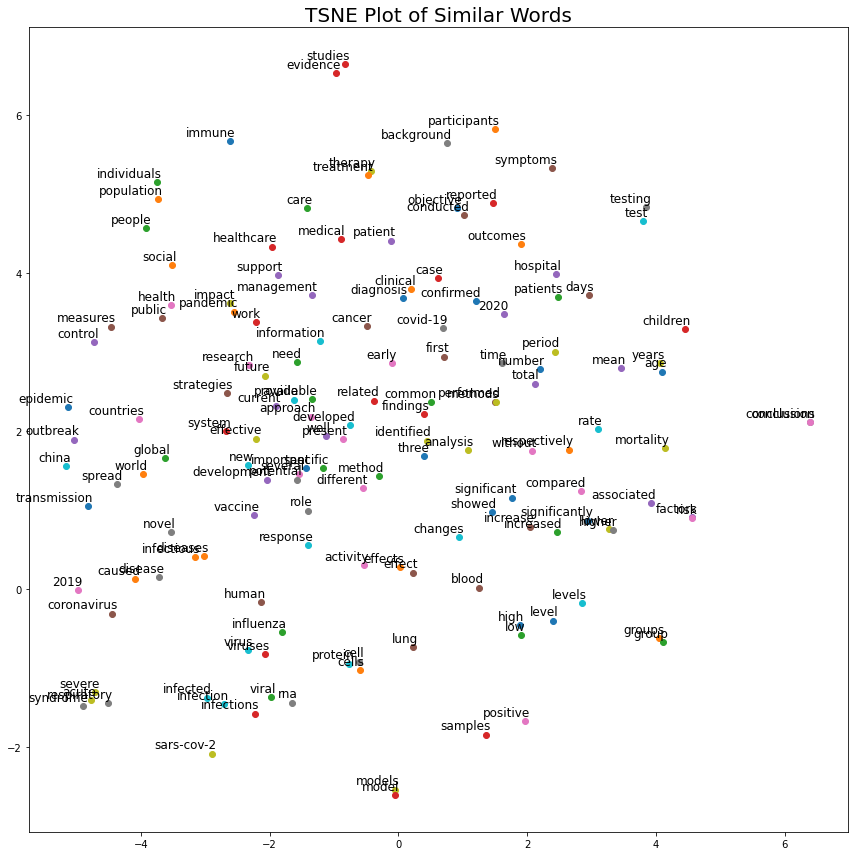

time: 3.07 s (started: 2021-04-10 22:59:02 +00:00)


In [ ]:
tsne_plot(df_we)

The TSNE plot shows the term "covid-19" in the center, surrounded by other relevant keywords. "Covid-19" is closely related to "diagnosis", "symptoms", and "patient". It is also related to "cancer", a high risk condition for being infected with covid-19. "Vaccine" is related to "strategies", "development", and "important". "Coronavirus" is related to "disease", "novel", "global", "outbreak", and "epidemic".

Similarities among these keywords make sense given the context of study.

# TFIDF Vectorization and Vectorizer Analysis

Using the term frequency–inverse document frequency (TF-IDF) vectorizer, we can get a sparse matrix with numerical representations of the importance of each word in the corpus. After that, we can visualize the top 20 words with the most importance numerical values.

In [ ]:
# Prepare the X feature
X = df_cleaned.abstract

time: 1.74 ms (started: 2021-04-11 06:11:18 +00:00)


In [ ]:
# TF-IDF with only alphabetical words
tfidf = TfidfVectorizer(max_features=1500, analyzer='word', token_pattern=r'(?u)\b[A-Za-z]+\b',
                        stop_words='english', ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)
X_tfidf.shape

(321013, 1500)

time: 35.6 s (started: 2021-04-11 06:11:18 +00:00)


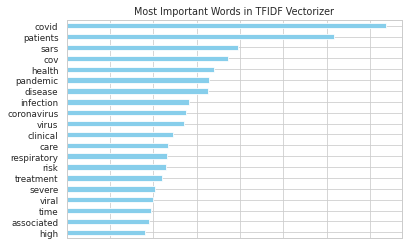

time: 388 ms (started: 2021-04-10 19:27:32 +00:00)


In [ ]:
# Show the 20 most frequent words
sns.set_theme(style='whitegrid')
sns.set_context('paper')
word_count = pd.DataFrame({'word': tfidf.get_feature_names(), 'count': np.asarray(X_tfidf.sum(axis=0))[0]})
word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh', legend=False, color='skyblue')
plt.title('Most Important Words in TFIDF Vectorizer')
ax1 = plt.axes()
ax1.axes.xaxis.set_ticklabels([])
y_axis = ax1.axes.get_yaxis()
y_axis.label.set_visible(False)
plt.show()

The top 20 words in the TF-IDF vectorizer are similar to what we would expect from the results of previous models.

# Random Sampling PCA and Mini-Batch KMeans Clustering

In order to maintain efficiency while using the elboa method to find the optimal k value for the k-means model, PCA is implemented before running the k-means algorithm. Within PCA dimensionality reduction, only 30000 rows of X feature are randomly sampled due to memory overload (more samples would lead to the crashing of PCA).

Mini-batch KMeans is better suited for processing large scale data (n_samples > 10k). It is an online implementation that does incremental updates of the centers positions using mini-batches.

In [ ]:
# Sampling and PCA
X_pca = X.sample(30000, random_state=1)
X_pca = tfidf.transform(X_pca)
pca = PCA(n_components=0.95, random_state=1)
X_pca = pca.fit_transform(X_pca.toarray())
X_pca.shape

(30000, 1266)

time: 23 s (started: 2021-04-11 06:11:54 +00:00)


Text(0.5, 1.0, 'Elbow method')

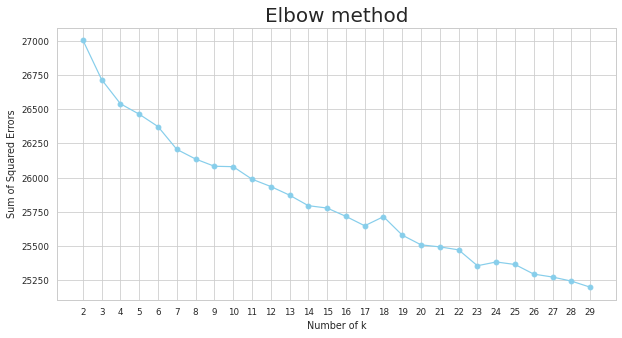

time: 1min 38s (started: 2021-04-11 06:12:17 +00:00)


In [ ]:
# Find optimal k
errors = []
k_range = range(2, 30)
for k in k_range:
    k_means = MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=4096,
                              random_state=1).fit(X_pca)
    errors.append(k_means.inertia_)

plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.set_context('paper')
plt.plot(k_range, errors, marker='o', color='skyblue')
plt.xticks(k_range)
plt.xlabel('Number of k')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow method', fontsize=20)

Using the elbow method, we can see in the plot above that the decline of the sum of squared errors (or distortion) becomes considerably less after k=17. Since the turning point is at k = 17, we will use 17 as the number of clusters for the KMeans model below.

In [ ]:
# Using k=20 to construct mini-batch kmeans model
k_means = MiniBatchKMeans(n_clusters=17, init_size=1024, batch_size=4096, random_state=1)
y = k_means.fit_predict(X_tfidf)

time: 2.71 s (started: 2021-04-11 06:15:24 +00:00)


After training the mini-batch KMeans clustering, we can use this model to fit and predict the cluster label for each paper.

## Cluster Evaluation using Classification

With the labels generated by KMeans, we can proceed to use a simple supervised classifier to try evaluating the clustering predictions.

Using train-test-split and an SGD classifier, we can check the appropriateness of the predicted KMeans clusters as valid labels.

In [ ]:
# Fit and predict the clusters using a simple SGD Classifier
X_train, X_test, y_train, y_test = train_test_split(X_tfidf.toarray(), y, test_size=0.2, random_state=1)

sgd = SGDClassifier(max_iter=10000, random_state=1, n_jobs=-1).fit(X_train, y_train)

y_train_pred = sgd.predict(X_train)
print(f'Train Accuracy: {accuracy_score(y_train, y_train_pred)}')

y_pred = sgd.predict(X_test)
print(f'Validation Accuracy: {accuracy_score(y_test, y_pred)}')

Train Accuracy: 0.909049491842218
Validation Accuracy: 0.9031509431023472
time: 1min 3s (started: 2021-04-11 06:21:57 +00:00)


In [ ]:
print(classification_report(y_test, y_pred, target_names=["{:02d}".format(x) for x in range(1, 18)]))

              precision    recall  f1-score   support

          01       0.87      0.98      0.92      4282
          02       0.88      0.96      0.92      4676
          03       0.94      0.89      0.92      2570
          04       0.90      0.90      0.90      5428
          05       0.91      0.89      0.90      5178
          06       0.91      0.86      0.88       839
          07       0.94      0.93      0.93      1957
          08       0.95      0.88      0.91      1644
          09       0.87      0.94      0.90     12784
          10       0.94      0.88      0.91      2001
          11       0.92      0.77      0.84      5298
          12       0.91      0.83      0.87      5147
          13       0.92      0.91      0.91      1130
          14       0.92      0.88      0.90      2362
          15       0.92      0.94      0.93      3545
          16       0.93      0.96      0.94      1354
          17       0.92      0.92      0.92      4008

    accuracy              

The calidation accuracy and the classification report show that the cluster labels are fairly accurate for classifying the research papers in our data.

## Cluster Keywords

### K-Means Clustering Keywords

Since the K-Means clusters seem to be reasonably meaningful from the previous classification, we can take a look at the keywords from each cluster in order to gain insights.

In [ ]:
# Using the predicted kmeans clusters (tfidf-supported) to check cluster keywords
def get_top_keywords(data, kmclusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(kmclusters).mean()
    for i, val in df.iterrows():
        print('\nCluster {}'.format(i+1))
        print(', '.join([labels[t] for t in np.argsort(val)[-n_terms:]]))

get_top_keywords(X_tfidf, y, tfidf.get_feature_names(), 10)


Cluster 1
acute, virus, severe, syndrome, respiratory, infection, covid, coronavirus, sars, cov

Cluster 2
admission, icu, clinical, risk, severe, disease, hospital, mortality, covid, patients

Cluster 3
cell, cells, host, replication, binding, virus, viral, rna, proteins, protein

Cluster 4
practice, services, patient, medical, health, healthcare, patients, pandemic, covid, care

Cluster 5
spread, model, crisis, distancing, measures, economic, countries, pandemic, covid, social

Cluster 6
impact, india, health, march, measures, air, pandemic, period, covid, lockdown

Cluster 7
resection, performed, technique, operative, complications, postoperative, surgical, patients, laparoscopic, surgery

Cluster 8
covid, protease, activity, inhibitors, cov, sars, antiviral, compounds, drugs, drug

Cluster 9
method, disease, models, analysis, different, new, time, research, data, model

Cluster 10
sensitivity, test, positive, testing, detection, sars, cov, samples, rt, pcr

Cluster 11
trial, strok